In [1]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
import re
import os
import io


# from tqdm import tqdm_notebook 
from tqdm import tqdm 
import random

import sentencepiece as spm
from konlpy.tag import Mecab

print(tf.__version__)
print(pd.__version__)
print(np.__version__)

2.8.0
1.5.3
1.24.2


# Step1. 데이터 불러오기

In [2]:
data_dir = os.getenv("HOME") + '/aiffel/s_DATA'
tokenizer_name = 'spm'

In [3]:
# train data load
data_dir = os.getenv('HOME')+'/aiffel/s_DATA/pickle' # 파일 경로 지정
data_train_path = data_dir+f"/data_train_{tokenizer_name}_16000_spc_0606.pkl"
data_test_path = data_dir+f"/data_test_{tokenizer_name}_16000_spc_0606.pkl"
full_data = pd.read_pickle(data_train_path, 'gzip')
full_data_test = pd.read_pickle(data_test_path, 'gzip')

In [4]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2447480 entries, 0 to 2448279
Data columns (total 7 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   reg       object
 1   text      object
 2   pair      object
 3   dial      object
 4   eng       object
 5   toks_en   object
 6   toks_dec  object
dtypes: object(7)
memory usage: 149.4+ MB


In [5]:
full_data_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800 entries, 95559 to 1383009
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   reg       800 non-null    object
 1   text      800 non-null    object
 2   pair      800 non-null    object
 3   dial      800 non-null    object
 4   eng       800 non-null    object
 5   toks_en   800 non-null    object
 6   toks_dec  800 non-null    object
dtypes: object(7)
memory usage: 50.0+ KB


In [6]:
regs = full_data.reg.unique()

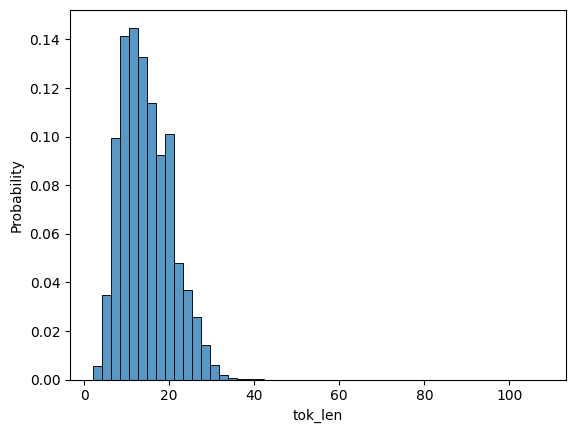

In [7]:
import seaborn as sns
full_data['tok_len'] = full_data['toks_en'].apply(lambda x : len(x))
sns.histplot(x='tok_len',data = full_data, bins= 50,stat='probability' )
plt.show()

In [8]:
full_data

,reg,text,pair,dial,eng,toks_en,toks_dec,tok_len
0,cc,적극성을 나도 뭐든 나서서 적극성 있게 이렇게,(이케)/(이렇게),적극성을 나도 뭐든 나서서 적극성 있게 이케,<cc> With acti haveness I took any acti havene...,"[53, 7, 801, 1186, 4669, 10, 271, 241, 1186, 4...","[1, 568, 4026, 4519, 98, 4498, 719, 50, 568, 4...",12
1,cc,그러니까 소심함이 쪼끔 강해서 그런 거지,(그니까)/(그러니까),그니까 소심함이 쪼끔 강해서 그런 거지,<cc> So it is because you are ti ami would,"[53, 7, 41, 11, 12, 45, 15, 21, 51, 848, 25]","[1, 67, 9966, 5403, 260, 190, 276, 27, 379, 2]",11
2,cc,그 소심함이 아니라 조금 네가 적극적인 면도 어떤 면에서는 있을 거라고 생각해.,(쫌)/(조금) (니가)/(너가),그 소심함이 아니라 쫌 니가 적극적인 면도 어떤 면에서는 있을 거라고 생각해.,<cc> You are a little acti have about this It ...,"[53, 7, 48, 21, 13, 36, 1186, 24, 55, 30, 40, ...","[1, 13, 9966, 5403, 317, 16, 256, 568, 4026, 5...",17
3,cc,적극적으로 뭔가 딱딱 나서서 그래도 이렇게,(이케)/(이렇게),적극적으로 뭔가 딱딱 나서서 그래도 이케,<cc> Astigiously something hard comes up like ...,"[53, 7, 388, 659, 1445, 8779, 80, 143, 266, 83...","[1, 12364, 157, 3945, 719, 50, 158, 70, 2]",12
4,cc,끊고 맺고 이렇게 해야지 적극성을 하면서 내 자존감도 높여봐와서 이렇게 하는데,(이케)/(이렇게),끊고 맺고 이렇게 해야지 적극성을 하면서 내 자존감도 높여봐와서 이케 하는데,<cc> You have to cut it off and make it like t...,"[53, 7, 48, 24, 17, 365, 11, 236, 18, 150, 11,...","[1, 8385, 6602, 33, 53, 1281, 568, 4026, 4519,...",21
...,...,...,...,...,...,...,...,...
2448275,jj,계속 기다리고 있었어,(있언)/(있었어),계속 기다리고 있언,<jj> I have been waiting for it,"[53, 4, 10, 24, 112, 975, 52, 11]","[1, 192, 4663, 960, 2]",8
2448276,jj,다른 건 다 작동도 안 되는 거야,(거)/(거야),다른 건 다 작동도 안 되는 거,<jj> Everything else does not work,"[53, 4, 1389, 280, 118, 20, 162]","[1, 182, 129, 26, 1535, 502, 14, 18, 208, 15, 2]",7
2448277,jj,고객 응대도 안 해주는 거야,(거)/(거야),고객 응대도 안 해주는 거,<jj> They do not even serve customers,"[53, 4, 189, 22, 20, 94, 1864, 1162]","[1, 6478, 175, 140, 14, 18, 2673, 15, 2]",8
2448278,jj,차라리 샀으면 어떻게 안 하는데,(사시민)/(샀으면) (어떵)/(어떻게) (하는디)/(하는데),차라리 사시민 어떵 안 하는디,<jj> If I bought it what would I do not do,"[53, 4, 77, 10, 227, 11, 73, 25, 10, 22, 20, 22]","[1, 1542, 96, 3030, 203, 18, 612, 2]",12


In [9]:
full_data.groupby(full_data['reg'])['tok_len'].mean()

reg
cc    17.487942
jd    15.798906
jj    13.309772
kw    13.155958
Name: tok_len, dtype: float64

In [10]:
full_data['tok_cat'] = pd.qcut(full_data['tok_len'], [0,0.9,0.9999,1],labels =[1,2,3])

In [11]:
full_data

,reg,text,pair,dial,eng,toks_en,toks_dec,tok_len,tok_cat
0,cc,적극성을 나도 뭐든 나서서 적극성 있게 이렇게,(이케)/(이렇게),적극성을 나도 뭐든 나서서 적극성 있게 이케,<cc> With acti haveness I took any acti havene...,"[53, 7, 801, 1186, 4669, 10, 271, 241, 1186, 4...","[1, 568, 4026, 4519, 98, 4498, 719, 50, 568, 4...",12,1
1,cc,그러니까 소심함이 쪼끔 강해서 그런 거지,(그니까)/(그러니까),그니까 소심함이 쪼끔 강해서 그런 거지,<cc> So it is because you are ti ami would,"[53, 7, 41, 11, 12, 45, 15, 21, 51, 848, 25]","[1, 67, 9966, 5403, 260, 190, 276, 27, 379, 2]",11,1
2,cc,그 소심함이 아니라 조금 네가 적극적인 면도 어떤 면에서는 있을 거라고 생각해.,(쫌)/(조금) (니가)/(너가),그 소심함이 아니라 쫌 니가 적극적인 면도 어떤 면에서는 있을 거라고 생각해.,<cc> You are a little acti have about this It ...,"[53, 7, 48, 21, 13, 36, 1186, 24, 55, 30, 40, ...","[1, 13, 9966, 5403, 317, 16, 256, 568, 4026, 5...",17,1
3,cc,적극적으로 뭔가 딱딱 나서서 그래도 이렇게,(이케)/(이렇게),적극적으로 뭔가 딱딱 나서서 그래도 이케,<cc> Astigiously something hard comes up like ...,"[53, 7, 388, 659, 1445, 8779, 80, 143, 266, 83...","[1, 12364, 157, 3945, 719, 50, 158, 70, 2]",12,1
4,cc,끊고 맺고 이렇게 해야지 적극성을 하면서 내 자존감도 높여봐와서 이렇게 하는데,(이케)/(이렇게),끊고 맺고 이렇게 해야지 적극성을 하면서 내 자존감도 높여봐와서 이케 하는데,<cc> You have to cut it off and make it like t...,"[53, 7, 48, 24, 17, 365, 11, 236, 18, 150, 11,...","[1, 8385, 6602, 33, 53, 1281, 568, 4026, 4519,...",21,1
...,...,...,...,...,...,...,...,...,...
2448275,jj,계속 기다리고 있었어,(있언)/(있었어),계속 기다리고 있언,<jj> I have been waiting for it,"[53, 4, 10, 24, 112, 975, 52, 11]","[1, 192, 4663, 960, 2]",8,1
2448276,jj,다른 건 다 작동도 안 되는 거야,(거)/(거야),다른 건 다 작동도 안 되는 거,<jj> Everything else does not work,"[53, 4, 1389, 280, 118, 20, 162]","[1, 182, 129, 26, 1535, 502, 14, 18, 208, 15, 2]",7,1
2448277,jj,고객 응대도 안 해주는 거야,(거)/(거야),고객 응대도 안 해주는 거,<jj> They do not even serve customers,"[53, 4, 189, 22, 20, 94, 1864, 1162]","[1, 6478, 175, 140, 14, 18, 2673, 15, 2]",8,1
2448278,jj,차라리 샀으면 어떻게 안 하는데,(사시민)/(샀으면) (어떵)/(어떻게) (하는디)/(하는데),차라리 사시민 어떵 안 하는디,<jj> If I bought it what would I do not do,"[53, 4, 77, 10, 227, 11, 73, 25, 10, 22, 20, 22]","[1, 1542, 96, 3030, 203, 18, 612, 2]",12,1


In [12]:
full_data.loc[full_data['tok_cat']==3,'tok_len']

6376       46
17094      41
19558      42
23224      41
49301      51
           ..
2418065    41
2427831    42
2433567    59
2439219    42
2439622    43
Name: tok_len, Length: 235, dtype: int64

In [13]:
len(full_data.loc[full_data['tok_cat']==3,'tok_len'])

235

In [14]:
full_data.loc[full_data['tok_cat']==3,'tok_len'].agg([min,max])

min     41
max    108
Name: tok_len, dtype: int64

In [15]:
data_path = os.getenv('HOME') + '/workspace/saturi/'
sizes = 16009
SRC_VOCAB_SIZE = sizes
TGT_VOCAB_SIZE = sizes

enc_tokenizer = spm.SentencePieceProcessor()
enc_tokenizer.Load(data_path+'spm_enc_spm16000_spc.model')

dec_tokenizer = spm.SentencePieceProcessor()
dec_tokenizer.Load(data_path+f'spm_dec_{tokenizer_name}16000_spc.model')

dec_tokenizer.set_encode_extra_options("bos:eos")

True

# Step 2. 모델 불러오기

In [16]:
import wandb
wandb.login()

wandb: Currently logged in as: aeolian83 (saturi-lab). Use `wandb login --relogin` to force relogin


True

In [17]:
#wandb 설정
warmups = 8500
project_name = 'saturi_v_transformer_new_corpus_with_spellcheck'
run  = wandb.init(project = project_name ,
                  entity = 'saturi-lab',
                  config = {
                      'model_name':'Vanilla_Transformer',
                      'n_layers':6,
                      'd_model':512,
                      'n_heads':8,
                      'd_ff':2048,
                      'src_vocab_size':SRC_VOCAB_SIZE,
                      'tgt_vocab_size':TGT_VOCAB_SIZE,
                      'pos_len': 512,
                      'dropout':0.2,
                      'shared':True,
                      'warmups' : warmups,
                      'epochs':1,
                      'optimizer' :'ADAM',
                      'loss' : 'SparseCategoricalCrossentropy',
                      'metric' : 'bleu'
                  })
config = wandb.config

In [18]:
# config = {
#             'model_name':'Vanilla_Transformer',
#             'n_layers':6,
#             'd_model':512,
#             'n_heads':8,
#             'd_ff':2048,
#             'src_vocab_size':SRC_VOCAB_SIZE,
#             'tgt_vocab_size':TGT_VOCAB_SIZE,
#             'pos_len': 512,
#             'dropout':0.2,
#             'shared':True,
#             'warmups' : warmups,
#             'epochs':1,
#             'optimizer' :'ADAM',
#             'loss' : 'SparseCategoricalCrossentropy',
#             'metric' : 'bleu'
#                   }

In [19]:
import sys
sys.path.insert(0,os.getenv('HOME') + '/aiffel/saturi/MODEL/') # vanilla transformer 파일경로에서 불러오기 위해 설정
sys.path.insert(0,os.getenv('HOME') + '/aiffel/saturi/PRE/')
sys.path.insert(0,os.getenv('HOME') + '/aiffel/saturi/POST/')

In [20]:
from vanilla_transformer import Transformer, generate_masks

transformer = Transformer(
    n_layers=config.n_layers,
    d_model=config.d_model,
    n_heads=config.n_heads,
    d_ff=config.d_ff,
    src_vocab_size=config.src_vocab_size,
    tgt_vocab_size=config.tgt_vocab_size,
    pos_len=config.pos_len,
    dropout=config.dropout,
    shared=config.shared
)

2023-06-06 20:46:44.382964: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-06 20:46:44.387792: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-06 20:46:44.387891: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-06 20:46:44.389148: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [21]:
# from vanilla_transformer import Transformer, generate_masks

# transformer = Transformer(
#     n_layers=config['n_layers'],
#     d_model=config['d_model'],
#     n_heads=config['n_heads'],
#     d_ff=config['d_ff'],
#     src_vocab_size=config['src_vocab_size'],
#     tgt_vocab_size=config['tgt_vocab_size'],
#     pos_len=config['pos_len'],
#     dropout=config['dropout'],
#     shared=config['shared']
# )

## Learning Rate Scheduler를 선언하고, 이를 포함하는 Adam Optimazer를 선언

In [22]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=config['warmups']):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** np.array(-0.5)
        arg2 = step * np.array(self.warmup_steps ** -1.5)
        
        return np.array(self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

In [23]:
learningrate = LearningRateScheduler(512)

In [24]:
optimizer = tf.keras.optimizers.Adam(learningrate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

## Loss 함수를 정의
- loss 함수에서 mask는 어떤 역활을 하는가?
- tf.reduce_sum의 기능에 대해 확인

In [25]:
# Loss 함수 정의
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    # 로스함수에서  mask는 어떤 역활을 하는가?
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

## train_step 함수를 정의

In [26]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    
    return loss, enc_attns, dec_attns, dec_enc_attns, predictions

In [27]:
# Validating the model
@tf.function
def model_validate(src, tgt, model):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)
    predictions, enc_attns, dec_attns, dec_enc_attns = model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
    v_loss = loss_function(gold, predictions[:, :-1])
    
    return v_loss, predictions

In [28]:
# 학습 매니저 설정
from evaluation import evaluate, compute_metric, translate
full_data = full_data.sample(frac=1).copy()

In [29]:
def train_and_checkpoint(transformer, manager, EPOCHS):
    ckpt.restore(manager.latest_checkpoint)
    if manager.latest_checkpoint:
        print("Restored from {}".format(manager.latest_checkpoint))
    
    else:
        print("Initializing from scratch.")


    for epoch in range(EPOCHS):
        
        batch_size = 64
        buckets = iter(reversed(full_data['tok_cat'].unique().tolist()))

        for bucket in buckets :
            total_loss = 0     
            
            src_corpus = full_data.loc[full_data['tok_cat']==bucket,'toks_en'].values
            tgt_corpus = full_data.loc[full_data['tok_cat']==bucket,'toks_dec'].values
            src_valid_corpus = full_data_test['toks_en'].values
            tgt_valid_corpus = full_data_test['toks_dec'].values
            max_len = full_data.loc[full_data['tok_cat']==bucket,'tok_len'].max()

            if max_len > 380 :
                batch_size = 8

            if max_len > 512 : 
                max_len = 512


            enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post', maxlen=max_len)
            dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post', maxlen=max_len)
            enc_test = tf.keras.preprocessing.sequence.pad_sequences(src_valid_corpus, padding='post', maxlen=max_len)
            dec_test = tf.keras.preprocessing.sequence.pad_sequences(tgt_valid_corpus, padding='post', maxlen=max_len)
            
            idx_list = list(range(0, enc_train.shape[0], batch_size))
            random.shuffle(idx_list)

            t = tqdm(idx_list)
            
            for (batch, idx) in enumerate(t):
                batch_loss, enc_attns, dec_attns, dec_enc_attns, preds = train_step(enc_train[idx:idx+batch_size],
                                                                             dec_train[idx:idx+batch_size],
                                                                             transformer,
                                                                             optimizer)

                total_loss += batch_loss

                t.set_description_str('Bucket %2d' % (bucket))
                t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
            
                wandb.log({"train_loss": (total_loss.numpy() / (batch + 1)),})
            
            #validation
            total_loss_val = 0
            val_size=25
            tv = tqdm(range(0,enc_test.shape[0], val_size))
            
            for (batch_val,test_idx) in enumerate(tv) :
                val_loss, val_preds = model_validate(enc_test[test_idx : test_idx + val_size],
                                          dec_test[test_idx : test_idx + val_size],
                                          transformer)
                total_loss_val += val_loss
                tv.set_postfix_str('val_Loss %.4f' % (total_loss_val.numpy() / (batch_val + 1)))
                
                wandb.log({"valid_loss" : (total_loss_val.numpy() / (batch_val + 1))                           })

            save_path = manager.save()
            print("Saved checkpoint for step {}: {}".format(int(ckpt.step), save_path))
            
        # bleu score
        from datasets import load_metric

        bleu = load_metric("sacrebleu")
        test_translate = []
        bleu_valid_score = []
        
        test_text = full_data_test.eng.values
        test_tgt = full_data_test.dial.values
        
        for i in tqdm(range(len(test_text))) :
            trans = translate(test_text[i], transformer, enc_tokenizer, dec_tokenizer, verbose =False)
            test_translate.append(trans)
            label = dec_tokenizer.decode(test_tgt[i])
            result = bleu.compute(predictions=[trans], references=[[label]], smooth_method='add-k')['score']
            bleu_valid_score.append(result)

        sum(bleu_valid_score)/len(test_text)
        wandb.log({"bleu": sum(bleu_valid_score)/len(test_text)})

        full_data_test['bleu'] = np.array(bleu_valid_score)
        full_data_test['pred'] = test_translate
            
directory = os.getenv('HOME') + '/aiffel/saturi/MODEL/'
ckpt = tf.train.Checkpoint(step = tf.Variable(1), optimizer = optimizer , transformer = transformer)
manager = tf.train.CheckpointManager(ckpt, directory +f'tf_{tokenizer_name}16000_ckpt_final_0603_newcorpus_spc',max_to_keep=10)

In [30]:
manager.latest_checkpoint

In [31]:
ckpt.restore(manager.latest_checkpoint)

In [32]:
for _ in range(7):
    run  = wandb.init(project = project_name,
                     entity = 'saturi-lab',
                     config = {
                         'model_name':'Vanilla_Transformer',
                         'n_layers':6,
                         'd_model':512,
                         'n_heads':8,
                         'd_ff':2048,
                         'src_vocab_size':SRC_VOCAB_SIZE,
                         'tgt_vocab_size':TGT_VOCAB_SIZE,
                         'pos_len': 512,
                         'dropout':0.2,
                         'shared':True,
                         'warmups' : warmups,
                         'epochs':1,
                         'optimizer' :'ADAM',
                         'loss' : 'SparseCategoricalCrossentropy',
                         'metric' : 'bleu'
                     })
    train_and_checkpoint(transformer, manager, config.epochs)

Initializing from scratch.


100%|█████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 18.37it/s, val_Loss 10.9584]


Saved checkpoint for step 1: /home/aeolian83/aiffel/saturi/MODEL/tf_spm16000_ckpt_final_0603_newcorpus_spc/ckpt-1


100%|██████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 28.52it/s, val_Loss 5.8731]


Saved checkpoint for step 1: /home/aeolian83/aiffel/saturi/MODEL/tf_spm16000_ckpt_final_0603_newcorpus_spc/ckpt-2


100%|██████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 30.83it/s, val_Loss 4.1131]


Saved checkpoint for step 1: /home/aeolian83/aiffel/saturi/MODEL/tf_spm16000_ckpt_final_0603_newcorpus_spc/ckpt-3


100%|█████████████████████████████████████████████████████████████████████████████████| 800/800 [07:29<00:00,  1.78it/s]


bleu,▁
train_loss,█▇▆▅▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,██████████████▃▃▃▃▃▃▃▃▃▃▃▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁
bleu,15.41536
train_loss,4.52361
valid_loss,4.11306


Restored from /home/aeolian83/aiffel/saturi/MODEL/tf_spm16000_ckpt_final_0603_newcorpus_spc/ckpt-3


100%|██████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 32.21it/s, val_Loss 4.0920]


Saved checkpoint for step 1: /home/aeolian83/aiffel/saturi/MODEL/tf_spm16000_ckpt_final_0603_newcorpus_spc/ckpt-4


100%|██████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 76.61it/s, val_Loss 3.8571]


Saved checkpoint for step 1: /home/aeolian83/aiffel/saturi/MODEL/tf_spm16000_ckpt_final_0603_newcorpus_spc/ckpt-5


100%|██████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 85.35it/s, val_Loss 3.8653]


Saved checkpoint for step 1: /home/aeolian83/aiffel/saturi/MODEL/tf_spm16000_ckpt_final_0603_newcorpus_spc/ckpt-6


100%|█████████████████████████████████████████████████████████████████████████████████| 800/800 [07:56<00:00,  1.68it/s]


bleu,▁
train_loss,█▇▆▅▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,▇██▆▇▆▇▇▇▇▇▇▇█▁▂▁▂▂▃▃▃▃▃▄▄▄▂▄▃▄▄▄▄▄▃▃▄▄▄
bleu,16.00168
train_loss,3.76033
valid_loss,3.8653


Restored from /home/aeolian83/aiffel/saturi/MODEL/tf_spm16000_ckpt_final_0603_newcorpus_spc/ckpt-6


100%|██████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 32.10it/s, val_Loss 3.8122]


Saved checkpoint for step 1: /home/aeolian83/aiffel/saturi/MODEL/tf_spm16000_ckpt_final_0603_newcorpus_spc/ckpt-7


100%|██████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 76.95it/s, val_Loss 3.6326]


Saved checkpoint for step 1: /home/aeolian83/aiffel/saturi/MODEL/tf_spm16000_ckpt_final_0603_newcorpus_spc/ckpt-8


100%|██████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 97.49it/s, val_Loss 3.7546]


Saved checkpoint for step 1: /home/aeolian83/aiffel/saturi/MODEL/tf_spm16000_ckpt_final_0603_newcorpus_spc/ckpt-9


100%|█████████████████████████████████████████████████████████████████████████████████| 800/800 [07:46<00:00,  1.71it/s]


bleu,▁
train_loss,█▇▆▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,▇▇▇▅▇▆▇▇▇▇▇▇▇█▂▂▁▃▂▄▃▄▄▄▅▅▅▄▆▅▆▆▇▇▇▆▆▇▇▇
bleu,16.50141
train_loss,3.52642
valid_loss,3.75459


Restored from /home/aeolian83/aiffel/saturi/MODEL/tf_spm16000_ckpt_final_0603_newcorpus_spc/ckpt-9


100%|██████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 32.38it/s, val_Loss 3.7212]


Saved checkpoint for step 1: /home/aeolian83/aiffel/saturi/MODEL/tf_spm16000_ckpt_final_0603_newcorpus_spc/ckpt-10


100%|██████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 74.52it/s, val_Loss 3.5545]


Saved checkpoint for step 1: /home/aeolian83/aiffel/saturi/MODEL/tf_spm16000_ckpt_final_0603_newcorpus_spc/ckpt-11


100%|█████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 100.13it/s, val_Loss 3.6710]


Saved checkpoint for step 1: /home/aeolian83/aiffel/saturi/MODEL/tf_spm16000_ckpt_final_0603_newcorpus_spc/ckpt-12


100%|█████████████████████████████████████████████████████████████████████████████████| 800/800 [07:51<00:00,  1.70it/s]


bleu,▁
train_loss,█▇▅▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂
valid_loss,▅▆▆▅▇▆▇█▇▇▇▇▇█▂▂▁▂▂▃▃▄▄▄▅▅▆▂▅▄▆▅▇▆▇▆▆▇▇▇
bleu,16.85048
train_loss,3.37395
valid_loss,3.67096


Restored from /home/aeolian83/aiffel/saturi/MODEL/tf_spm16000_ckpt_final_0603_newcorpus_spc/ckpt-12


100%|██████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 31.80it/s, val_Loss 3.6178]


Saved checkpoint for step 1: /home/aeolian83/aiffel/saturi/MODEL/tf_spm16000_ckpt_final_0603_newcorpus_spc/ckpt-13


100%|██████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 77.33it/s, val_Loss 3.4819]


Saved checkpoint for step 1: /home/aeolian83/aiffel/saturi/MODEL/tf_spm16000_ckpt_final_0603_newcorpus_spc/ckpt-14


100%|██████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 98.96it/s, val_Loss 3.6595]


Saved checkpoint for step 1: /home/aeolian83/aiffel/saturi/MODEL/tf_spm16000_ckpt_final_0603_newcorpus_spc/ckpt-15


100%|█████████████████████████████████████████████████████████████████████████████████| 800/800 [07:52<00:00,  1.69it/s]


bleu,▁
train_loss,█▇▅▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
valid_loss,▄▅▅▄▆▆▇▇▇▇▇▇▇█▂▂▁▃▃▄▄▄▄▅▅▅▆▂▆▄▇▆▇▇█▇▇███
bleu,17.03424
train_loss,3.25238
valid_loss,3.65949


Restored from /home/aeolian83/aiffel/saturi/MODEL/tf_spm16000_ckpt_final_0603_newcorpus_spc/ckpt-15


100%|██████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 31.99it/s, val_Loss 3.6023]


Saved checkpoint for step 1: /home/aeolian83/aiffel/saturi/MODEL/tf_spm16000_ckpt_final_0603_newcorpus_spc/ckpt-16


100%|██████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 74.84it/s, val_Loss 3.4539]


Saved checkpoint for step 1: /home/aeolian83/aiffel/saturi/MODEL/tf_spm16000_ckpt_final_0603_newcorpus_spc/ckpt-17


100%|██████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 98.48it/s, val_Loss 3.6548]


Saved checkpoint for step 1: /home/aeolian83/aiffel/saturi/MODEL/tf_spm16000_ckpt_final_0603_newcorpus_spc/ckpt-18


100%|█████████████████████████████████████████████████████████████████████████████████| 800/800 [07:48<00:00,  1.71it/s]


bleu,▁
train_loss,█▇▆▅▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
valid_loss,▃▄▅▃▆▆▇▇▇▇▇▇▇█▂▂▁▃▃▄▄▅▅▅▅▅▆▂▅▄▆▆▇▇▇▇▇███
bleu,17.10461
train_loss,3.14655
valid_loss,3.65478


Restored from /home/aeolian83/aiffel/saturi/MODEL/tf_spm16000_ckpt_final_0603_newcorpus_spc/ckpt-18


100%|██████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 32.14it/s, val_Loss 3.6029]


Saved checkpoint for step 1: /home/aeolian83/aiffel/saturi/MODEL/tf_spm16000_ckpt_final_0603_newcorpus_spc/ckpt-19


100%|██████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 75.66it/s, val_Loss 3.4482]


Saved checkpoint for step 1: /home/aeolian83/aiffel/saturi/MODEL/tf_spm16000_ckpt_final_0603_newcorpus_spc/ckpt-20


100%|██████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 99.28it/s, val_Loss 3.6526]


Saved checkpoint for step 1: /home/aeolian83/aiffel/saturi/MODEL/tf_spm16000_ckpt_final_0603_newcorpus_spc/ckpt-21


100%|█████████████████████████████████████████████████████████████████████████████████| 800/800 [08:02<00:00,  1.66it/s]


Text(0.5, 0, 'Train Step')

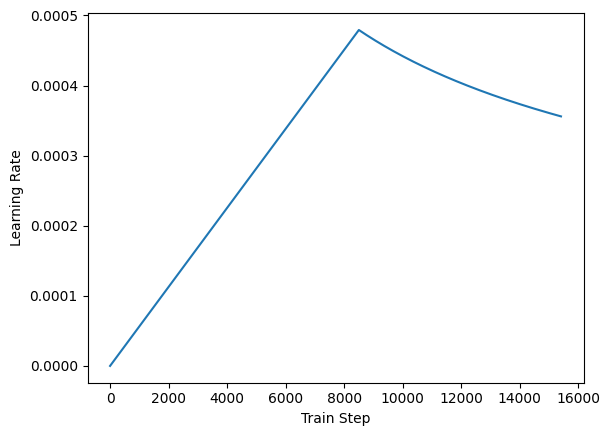

In [33]:
plt.plot(learningrate(tf.range(15412, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

In [34]:
from time import perf_counter

In [35]:
examples = ["<jj> what are you doing ?",'<cc> what are you doing ?','<gs> what are you doing ?','<jd> what are you doing ?','<kw> what are you doing ?']

In [36]:
start = perf_counter()
for example in examples :
    translate(example, transformer, enc_tokenizer, dec_tokenizer, verbose =True)
print(perf_counter() - start)

Input: <jj> what are you doing ?
Predicted translation: 뭐 하는 거?
Input: <cc> what are you doing ?
Predicted translation: 너는 뭐혀?
Input: <gs> what are you doing ?
Predicted translation: 니 혹시 뭐 우류?
Input: <jd> what are you doing ?
Predicted translation: 뭐 하는 겨?
Input: <kw> what are you doing ?
Predicted translation: 무신 짓이야?
1.3578917480190285


In [37]:
examples = ["<jj> i like this song .",'<cc> i like this song . ','<gs> i like this song . ','<jd> i like this song . ','<kw> i like this song . ']

In [38]:
start = perf_counter()
for example in examples :
    translate(example, transformer, enc_tokenizer, dec_tokenizer, verbose =True)
print(perf_counter() - start)

Input: <jj> i like this song .
Predicted translation: 이 노래 좋아마씨.
Input: <cc> i like this song . 
Predicted translation: 이 노래와 함께 그.
Input: <gs> i like this song . 
Predicted translation: 이 노래의 천지야.
Input: <jd> i like this song . 
Predicted translation: 이 노래 좋아야.
Input: <kw> i like this song . 
Predicted translation: 이딴 노래요.
1.6427699199994095


In [39]:
examples = ["<jj> Let's do homework together .","<cc> Let's do homework together .","<gs> Let's do homework together .","<jd> Let's do homework together .","<kw> Let's do homework together ."]

In [40]:
start = perf_counter()
for example in examples :
    translate(example, transformer, enc_tokenizer, dec_tokenizer, verbose =True)
print(perf_counter() - start)

Input: <jj> Let's do homework together .
Predicted translation: 숙제 같이 하게.
Input: <cc> Let's do homework together .
Predicted translation: 같이 숙제도 같이 햐.
Input: <gs> Let's do homework together .
Predicted translation: 난 우회전 해부렀잖아.
Input: <jd> Let's do homework together .
Predicted translation: 숙제를 같이 하게.
Input: <kw> Let's do homework together .
Predicted translation: 숙제를 어여 같이 해내세요.
1.8955887659976725


In [41]:
examples = ["<jj> Are you going to sleep ?","<cc> Are you going to sleep ?","<gs> Are you going to sleep ?","<jd> Are you going to sleep ?","<kw> Are you going to sleep ?"]

In [42]:
start = perf_counter()
for example in examples :
    translate(example, transformer, enc_tokenizer, dec_tokenizer, verbose =True)
print(perf_counter() - start)

Input: <jj> Are you going to sleep ?
Predicted translation: 자젠?
Input: <cc> Are you going to sleep ?
Predicted translation: 자겄어?
Input: <gs> Are you going to sleep ?
Predicted translation: 잠간 자나?
Input: <jd> Are you going to sleep ?
Predicted translation: 자겄어?
Input: <kw> Are you going to sleep ?
Predicted translation: 자나?
1.162439767998876


In [43]:
from datasets import load_metric

bleu = load_metric("sacrebleu")
test_translate = []
bleu_valid_score = []

test_text = full_data_test.eng.values
test_tgt = full_data_test.dial.values

for i in tqdm(range(len(test_text))) :
    trans = translate(test_text[i], transformer, enc_tokenizer, dec_tokenizer, verbose =False)
    test_translate.append(trans)
    label = dec_tokenizer.decode(test_tgt[i])
    result = bleu.compute(predictions=[trans], references=[[label]], smooth_method='add-k')['score']
    bleu_valid_score.append(result)

full_data_test['bleu'] = np.array(bleu_valid_score)
full_data_test['pred'] = test_translate

100%|█████████████████████████████████████████████████████████████████████████████████| 800/800 [08:01<00:00,  1.66it/s]


In [44]:
full_data_test.bleu.mean()

16.407278359951565

In [45]:
full_data_test.loc[:,['eng','reg','dial','pred','bleu']].sort_values('bleu', ascending=False).head()

data_dir = os.getenv('HOME')+'/aiffel/s_DATA' # 파일 경로 지정
full_data_test.to_csv(data_dir + f'/test_results_{tokenizer_name}16000_final_needs_merge_spc_0606.csv')


In [46]:
wandb.finish()

bleu,▁
train_loss,█▇▅▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
valid_loss,▃▄▅▄▆▆▇▇▇▇▇▇▇█▁▁▁▃▃▄▄▅▅▅▅▆▆▂▄▄▆▆▇▇▇▇▇███
bleu,16.40728
train_loss,3.05043
valid_loss,3.65263
